In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [25]:

# Đọc dữ liệu
df = pd.read_csv("D:/TImeserri/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep=';', index_col=0)
feats = ['4', '5', '6']
df = df[feats]

# Chuyển đổi index sang dạng datetime
df.index = pd.to_datetime(df.index, dayfirst=True)

# Sắp xếp dữ liệu theo ngày
df = df.sort_index()

# EDA

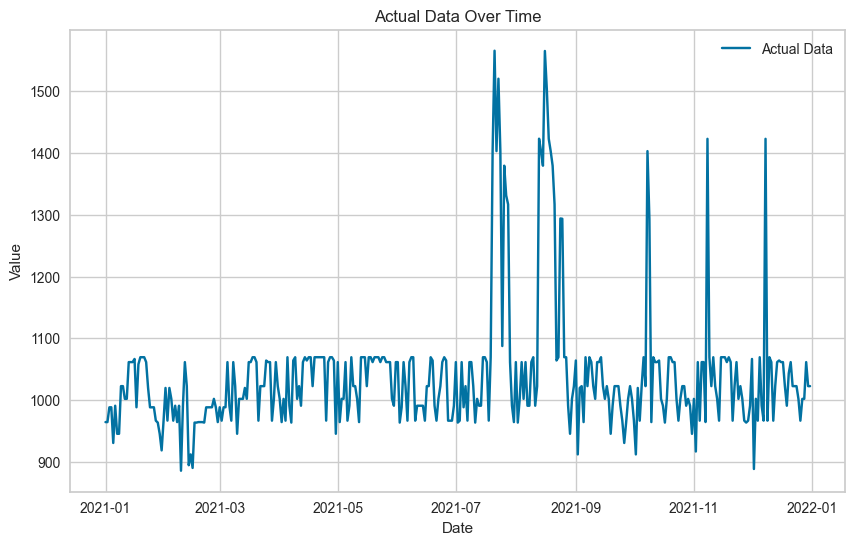

ADF Statistic: -4.639163513966705
p-value: 0.00010932055953615445


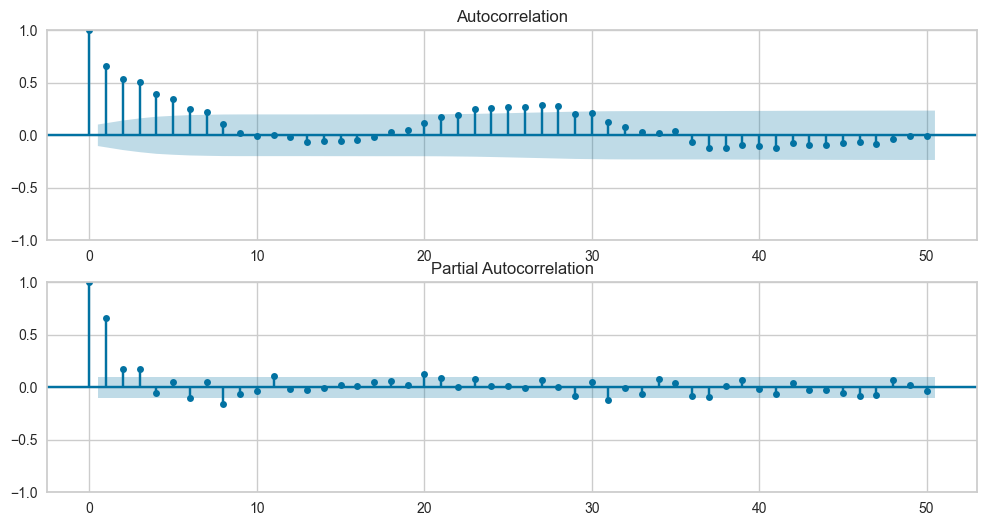

                               SARIMAX Results                                
Dep. Variable:                      4   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2107.481
Date:                Tue, 21 May 2024   AIC                           4220.963
Time:                        11:00:26   BIC                           4232.654
Sample:                    01-01-2021   HQIC                          4225.610
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2122      0.062      3.400      0.001       0.090       0.335
ma.L1         -0.6340      0.053    -12.056      0.000      -0.737      -0.531
sigma2      6253.4862    185.786     33.660      0.0

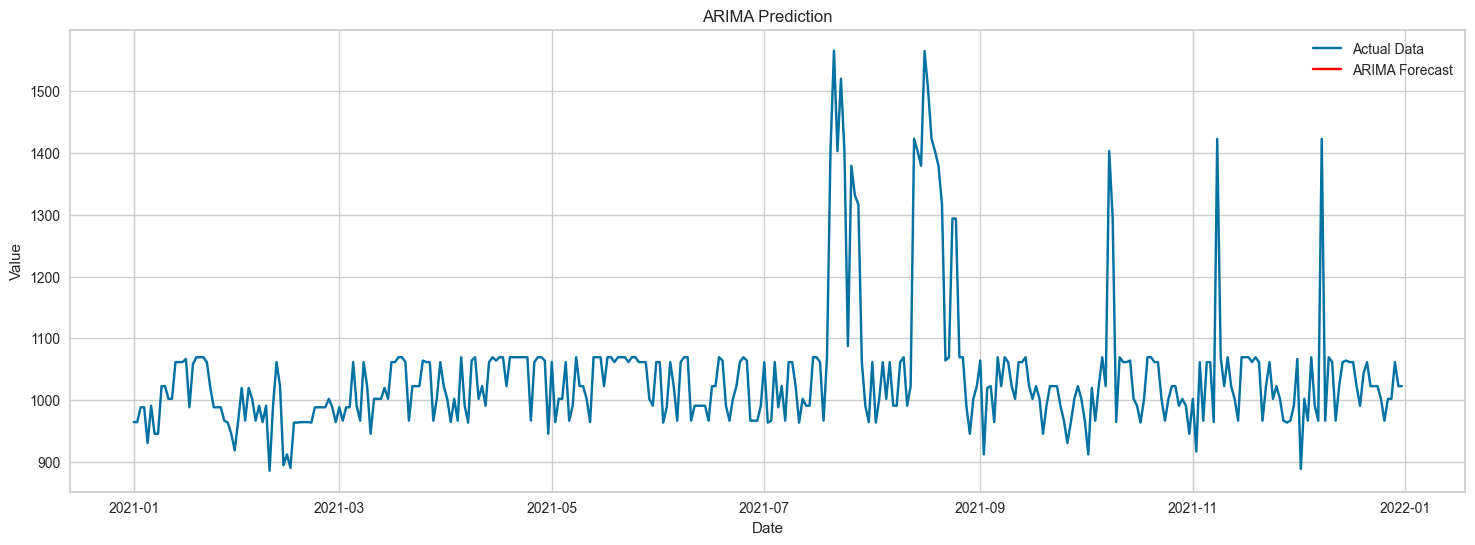

In [26]:


# EDA: Khám phá dữ liệu
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['4'], label='Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data Over Time')
plt.legend()
plt.show()

# Kiểm tra tính ổn định của chuỗi thời gian
result = adfuller(df['4'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['4'], ax=plt.gca(), lags=50)
plt.subplot(212)
plot_pacf(df['4'], ax=plt.gca(), lags=50)
plt.show()

# Xây dựng mô hình ARIMA
# Tìm giá trị (p,d,q) phù hợp dựa trên ACF và PACF

p = 1  # Số lượng giá trị trễ của chuỗi quan sát (AR)
d = 1  # Số lần lấy sai khác (differencing)
q = 1  # Số lượng giá trị trễ của sai số dự báo (MA)

model = ARIMA(df['4'], order=(p, d, q))
model_fit = model.fit()

# Tóm tắt mô hình
print(model_fit.summary())

# Dự đoán 10 ngày tiếp theo
n_forecast = 10
forecast = model_fit.forecast(steps=n_forecast)

# Tạo dataframe cho các giá trị dự đoán
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='D')
predictions_df = pd.DataFrame(forecast, index=future_dates, columns=['Predicted'])

# Hiển thị kết quả
print(predictions_df)

# Vẽ biểu đồ so sánh dữ liệu thực tế và dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['4'], label='Actual Data')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='ARIMA Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Prediction')
plt.show()




# Kalman

               Smoothed
Date                   
2021-01-01   598.462920
2021-01-02   726.909670
2021-01-03   850.126707
2021-01-04   919.680497
2021-01-05   925.257167
...                 ...
2021-12-27   995.869785
2021-12-28   999.015274
2021-12-29  1031.076958
2021-12-30  1026.727326
2021-12-31  1024.609544

[365 rows x 1 columns]


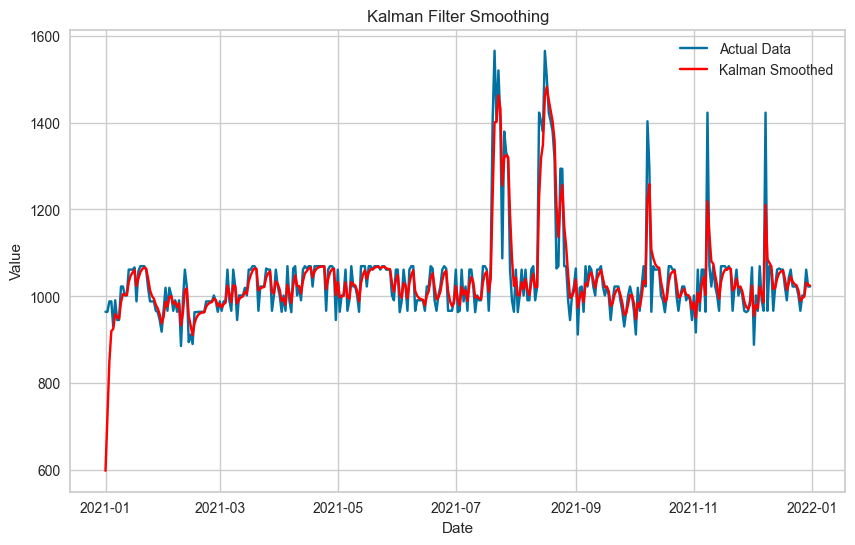

In [29]:
# Lấy cột dữ liệu cần làm mịn, giả sử cột '4' là cột cần làm mịn
data = df['4'].values

# Khởi tạo bộ lọc Kalman
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Áp dụng bộ lọc để làm mịn dữ liệu
state_means, state_covariances = kf.em(data).filter(data)

# Chuyển đổi kết quả làm mịn về DataFrame
smoothed_data = pd.DataFrame(state_means, index=df.index, columns=['Smoothed'])

# Hiển thị kết quả
print(smoothed_data)

# Vẽ biểu đồ so sánh dữ liệu thực tế và dữ liệu làm mịn
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['4'], label='Actual Data')
plt.plot(smoothed_data.index, smoothed_data['Smoothed'], label='Kalman Smoothed', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Kalman Filter Smoothing')
plt.show()

## LSTM

Epoch 1/10
314/314 - 5s - 17ms/step - loss: 0.0251
Epoch 2/10
314/314 - 3s - 10ms/step - loss: 0.0193
Epoch 3/10
314/314 - 3s - 10ms/step - loss: 0.0185
Epoch 4/10
314/314 - 3s - 10ms/step - loss: 0.0168
Epoch 5/10
314/314 - 3s - 10ms/step - loss: 0.0167
Epoch 6/10
314/314 - 3s - 10ms/step - loss: 0.0174
Epoch 7/10
314/314 - 3s - 10ms/step - loss: 0.0151
Epoch 8/10
314/314 - 3s - 10ms/step - loss: 0.0152
Epoch 9/10
314/314 - 3s - 10ms/step - loss: 0.0151
Epoch 10/10
314/314 - 3s - 10ms/step - loss: 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              Predicted
2022-01-01  1050.960205
2022-01-02  1062.561035
2022-01-03  1075.594360
2022-01-04  

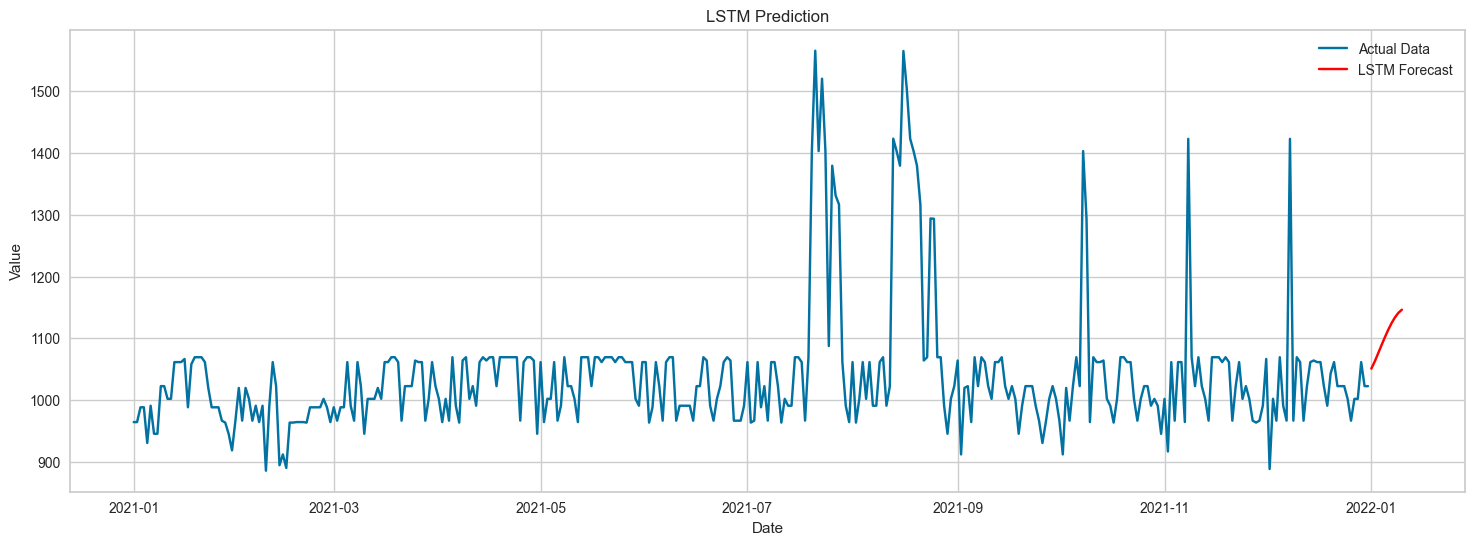

In [28]:

# Chọn cột dữ liệu cần dự đoán, giả sử cột '4' là cột cần dự đoán
data = df['4'].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Tạo các dữ liệu huấn luyện và nhãn
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 50
X, Y = create_dataset(scaled_data, look_back)

# Chuyển đổi dữ liệu để phù hợp với đầu vào của LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Tạo mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X, Y, epochs=10, batch_size=1, verbose=2)

# Dự đoán 10 ngày tiếp theo
last_values = scaled_data[-look_back:]
predictions = []

for _ in range(10):
    # Chuẩn bị dữ liệu để dự đoán
    last_values_reshaped = np.reshape(last_values, (1, look_back, 1))
    next_pred = model.predict(last_values_reshaped)
    
    # Lưu dự đoán
    predictions.append(next_pred[0, 0])
    
    # Cập nhật last_values
    last_values = np.append(last_values, next_pred)[-look_back:]

# Chuyển đổi dự đoán về giá trị gốc
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Tạo dataframe cho các giá trị dự đoán
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')
predictions_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted'])

# Hiển thị kết quả
print(predictions_df)

# Vẽ biểu đồ so sánh dữ liệu thực tế và dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index, df['4'], label='Actual Data')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='LSTM Forecast',color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LSTM Prediction')
plt.show()
